I love doing data analyses with pandas, numpy, sci-py etc., but I often need to run <a href="https://en.wikipedia.org/wiki/Repeated_measures_design">repeated measures ANOVAs</a>, which are not implemented in any major python libraries. <a href="http://pythonpsychologist.tumblr.com/post/139246503057/repeated-measures-anova-using-python">Python Psychologist</a> shows how to do repeated measures ANOVAs yourself in python, but I find using a widley distributed implementation comforting... 

In this post I show how to execute a repeated measures ANOVAs using the <a href="http://rpy2.bitbucket.org/">rpy2</a> library, which allows us to move data between python and R, and execute R commands from python. I use rpy2 to load the <a href="http://www.inside-r.org/packages/cran/car/docs/Anova">car</a> library and run the ANOVA. 

I will show how to run a one-way repeated measures ANOVA and a two-way repeated measures ANOVA. 

In [86]:
#first import the libraries I always use. 
import numpy as np, scipy.stats, pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline
pd.options.display.mpl_style = 'default'
plt.style.use('ggplot')
mpl.rcParams['font.family'] = ['Bitstream Vera Sans']


Below I use the random library to generate some fake data. I seed the random number generator with a one so that this analysis can be replicated. 

I will generated 3 conditions which represent 3 levels of a single variable.

The data are generated from a gaussian distribution. The second condition has a higher mean than the other two conditions.

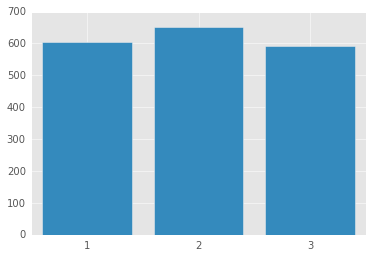

In [92]:
import random

random.seed(1) #seed random number generator
cond_1 = [random.gauss(600,30) for x in range(30)] #condition 1 has a mean of 600 and standard deviation of 30
cond_2 = [random.gauss(650,30) for x in range(30)] #u=650 and sd=30
cond_3 = [random.gauss(600,30) for x in range(30)] #u=600 and sd=30

plt.bar(np.arange(1,4),[np.mean(cond_1),np.mean(cond_2),np.mean(cond_3)],align='center') #plot data
plt.xticks([1,2,3]);

Next, I load rpy2 for ipython. I am doing these analyses with ipython in a <a href="http://jupyter.org/">jupyter notebook</a> (highly recommended). 


In [ ]:
%load_ext rpy2.ipython

Here's how to run the ANOVA. Note that this is a one-way anova with 3 levels of the factor. 

In [97]:
#pop the data into R
%Rpush cond_1 cond_2 cond_3 

#label the conditions
%R Factor <- c('Cond1','Cond2','Cond3')
#create a vector of conditions
%R idata <- data.frame(Factor) 

#combine data into single matrix
%R Bind <- cbind(cond_1,cond_2,cond_3) 
#generate linear model
%R model <- lm(Bind~1)

#load the car library. note this library must be installed.
%R library(car) 
#run anova
%R analysis <- Anova(model,idata=idata,idesign=~Factor,type="III") 
#create anova summary table
%R anova_sum = summary(analysis) 

#move the data from R to python
%Rpull anova_sum 
print anova_sum


Type III Repeated Measures MANOVA Tests:

------------------------------------------
 
Term: (Intercept) 

 Response transformation matrix:
       (Intercept)
cond_1           1
cond_2           1
cond_3           1

Sum of squares and products for the hypothesis:
            (Intercept)
(Intercept)   102473990

Sum of squares and products for error:
            (Intercept)
(Intercept)     78712.7

Multivariate Tests: (Intercept)
                 Df test stat approx F num Df den Df     Pr(>F)    
Pillai            1    0.9992 37754.33      1     29 < 2.22e-16 ***
Wilks             1    0.0008 37754.33      1     29 < 2.22e-16 ***
Hotelling-Lawley  1 1301.8736 37754.33      1     29 < 2.22e-16 ***
Roy               1 1301.8736 37754.33      1     29 < 2.22e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------------------------------------------
 
Term: Factor 

 Response transformation matrix:
       Factor1 Factor2
cond_1       1       0
cond_2       0    

The ANOVA table isn't pretty, but it works. As you can see, the ANOVA was wildly significant. 

Next, I generate data for a two-way (2x3) repeated measures ANOVA. Condition A is the same data as above. Condition B has a different pattern (2 is lower than 1 and 3), which should produce an interaction. 

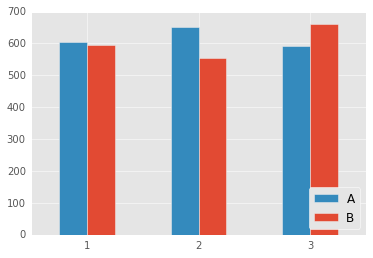

In [98]:
random.seed(1)

cond_1a = [random.gauss(600,30) for x in range(30)] #u=600,sd=30
cond_2a = [random.gauss(650,30) for x in range(30)] #u=650,sd=30
cond_3a = [random.gauss(600,30) for x in range(30)] #u=600,sd=30

cond_1b = [random.gauss(600,30) for x in range(30)] #u=600,sd=30
cond_2b = [random.gauss(550,30) for x in range(30)] #u=550,sd=30
cond_3b = [random.gauss(650,30) for x in range(30)] #u=650,sd=30

width = 0.25
plt.bar(np.arange(1,4)-width,[np.mean(cond_1a),np.mean(cond_2a),np.mean(cond_3a)],width)
plt.bar(np.arange(1,4),[np.mean(cond_1b),np.mean(cond_2b),np.mean(cond_3b)],width,color=plt.rcParams['axes.color_cycle'][0])
plt.legend(['A','B'],loc=4)
plt.xticks([1,2,3]);

In [84]:
%Rpush cond_1a cond_1b cond_2a cond_2b cond_3a cond_3b

%R Factor1 <- c('A','A','A','B','B','B')
%R Factor2 <- c('Cond1','Cond2','Cond3','Cond1','Cond2','Cond3')
%R idata <- data.frame(Factor1, Factor2)

#make sure the vectors appear in the same order as they appear in the dataframe
%R Bind <- cbind(cond_1a, cond_2a, cond_3a, cond_1b, cond_2b, cond_3b)
%R model <- lm(Bind~1)

%R library(car)
%R analysis <- Anova(model, idata=idata, idesign=~Factor1*Factor2, type="III")
%R anova_sum = summary(analysis)
%Rpull anova_sum

print anova_sum


Type III Repeated Measures MANOVA Tests:

------------------------------------------
 
Term: (Intercept) 

 Response transformation matrix:
        (Intercept)
cond_1a           1
cond_2a           1
cond_3a           1
cond_1b           1
cond_2b           1
cond_3b           1

Sum of squares and products for the hypothesis:
            (Intercept)
(Intercept)   401981075

Sum of squares and products for error:
            (Intercept)
(Intercept)    185650.5

Multivariate Tests: (Intercept)
                 Df test stat approx F num Df den Df     Pr(>F)    
Pillai            1    0.9995 62792.47      1     29 < 2.22e-16 ***
Wilks             1    0.0005 62792.47      1     29 < 2.22e-16 ***
Hotelling-Lawley  1 2165.2575 62792.47      1     29 < 2.22e-16 ***
Roy               1 2165.2575 62792.47      1     29 < 2.22e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------------------------------------------
 
Term: Factor1 

 Response transformation matrix:

Again, the anova table isn't too pretty. 

This obviously isn't the most exciting post in the world, but its a nice bit of code to have in your back pocket if you're doing experimental analyses in python.